In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.data_loader import load_clean_data, get_experimental_dataset, feature_definitions, target_col_name
from src.drift_injection import inject_synthetic_drift
from src.detectors import RiverCompatiblePCA
from src.experiments import run_comparison_experiment, run_adaptive_forecasting_experiment

In [3]:
DATA_DIR = Path("../data/processed/")

df = load_clean_data(DATA_DIR)

all_features = df.select_dtypes(include=[np.number]).columns.tolist()

print(df.shape)
print(f"Number of features: {len(all_features)}")
df.head()

[INFO] Loaded data from: ../data/processed/data.parquet
[INFO] Shape before cleaning: (35041, 104)
[INFO] NaNs before cleaning: 42631
[INFO] Shape after cleaning: (35036, 104)
[INFO] Final NaN count: 0
(35036, 104)
Number of features: 104


,erzeugung_installierte_leistung__biomasse_mw,erzeugung_installierte_leistung__wasserkraft_mw,erzeugung_installierte_leistung__wind_offshore_mw,erzeugung_installierte_leistung__wind_onshore_mw,erzeugung_installierte_leistung__photovoltaik_mw,erzeugung_installierte_leistung__sonstige_erneuerbare_mw,erzeugung_installierte_leistung__braunkohle_mw,erzeugung_installierte_leistung__steinkohle_mw,erzeugung_installierte_leistung__erdgas_mw,erzeugung_installierte_leistung__pumpspeicher_mw,...,lastfluss_ch__fahrplaene_mw,lastfluss_ch__physikalische_lastfluesse_mw,lastfluss_fr__fahrplaene_mw,lastfluss_fr__physikalische_lastfluesse_mw,lastverlauf_netzeinspeisung__last_mw,regelzonenlast__prognose_mw,regelzonenlast__ist_wert_mw,regelzonensaldo__regelzonensaldo_mw,vertikale_netzlast__prognose_mw,vertikale_netzlast__ist_wert_mw
ts,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:15:00,3998.0,2412.0,7387.0,26945.0,33673.0,102.0,37.0,2560.0,11535.0,1647.0,...,-62.0,-2624.0,-1341.0,243.0,6445.0,5830.0,5374.0,-168.0,2916.0,3133.0
2025-01-01 00:30:00,3998.0,2412.0,7387.0,26945.0,33673.0,102.0,37.0,2560.0,11535.0,1647.0,...,-62.0,-2634.0,-1341.0,293.0,6302.0,5740.0,5352.0,-73.0,2887.0,3090.0
2025-01-01 00:45:00,3998.0,2412.0,7387.0,26945.0,33673.0,102.0,37.0,2560.0,11535.0,1647.0,...,-62.0,-2657.0,-1341.0,321.0,6471.0,5692.0,5277.0,15.0,2856.0,3018.0
2025-01-01 01:00:00,3998.0,2412.0,7387.0,26945.0,33673.0,102.0,37.0,2560.0,11535.0,1647.0,...,-62.0,-2728.0,-1341.0,326.0,6754.0,5655.0,5259.0,-15.0,2832.0,3016.0
2025-01-01 01:15:00,3998.0,2412.0,7387.0,26945.0,33673.0,102.0,37.0,2560.0,11535.0,1647.0,...,-62.0,-2756.0,-1168.0,308.0,6867.0,5593.0,5234.0,-9.0,2828.0,3015.0


In [4]:
# 1. Load data
# Adjust path to your data directory
data_dir = Path("../data/processed/") 
df_full = load_clean_data(data_dir)

# 2. Test Feature Sets (Step 2 Verification)
print("\n--- TESTING SCENARIO GENERATION ---")

# Scenario A: Low Dim
print("1. Scenario Low:")
X_low, y = get_experimental_dataset(df_full, scenario="low")

# Scenario B: Mid Dim
print("\n2. Scenario Mid:")
X_mid, y = get_experimental_dataset(df_full, scenario="mid")

# Scenario C: High Dim (Real World Max)
print("\n3. Scenario High:")
X_high, y = get_experimental_dataset(df_full, scenario="high")

# Scenario D: Ultra High (Stress Test for RO2)
print("\n4. Scenario Noise:")
X_noise, y = get_experimental_dataset(df_full, scenario="noise")

# 3. Leakage Check
# Verify that the target variable is NOT present in the features
leakage_check = "verbrauch_realisiert__netzlast_mwh" in X_low.columns
print(f"\n[CHECK] Is target in features? {leakage_check} (Should be False)")

[INFO] Loaded data from: ../data/processed/data.parquet
[INFO] Shape before cleaning: (35041, 104)
[INFO] NaNs before cleaning: 42631
[INFO] Shape after cleaning: (35036, 104)
[INFO] Final NaN count: 0

--- TESTING SCENARIO GENERATION ---
1. Scenario Low:
[INFO] Dataset prepared for scenario 'low': X shape=(35036, 10), y shape=(35036,)

2. Scenario Mid:
[INFO] Dataset prepared for scenario 'mid': X shape=(35036, 40), y shape=(35036,)

3. Scenario High:
[INFO] Dataset prepared for scenario 'high': X shape=(35036, 103), y shape=(35036,)

4. Scenario Noise:
[INFO] Added 50 synthetic noise features for scenario 'noise'.
[INFO] Dataset prepared for scenario 'noise': X shape=(35036, 153), y shape=(35036,)

[CHECK] Is target in features? False (Should be False)


[INFO] Dataset prepared for scenario 'mid': X shape=(35036, 40), y shape=(35036,)
[INFO] Injecting drift into 12/40 features starting at index 20000.


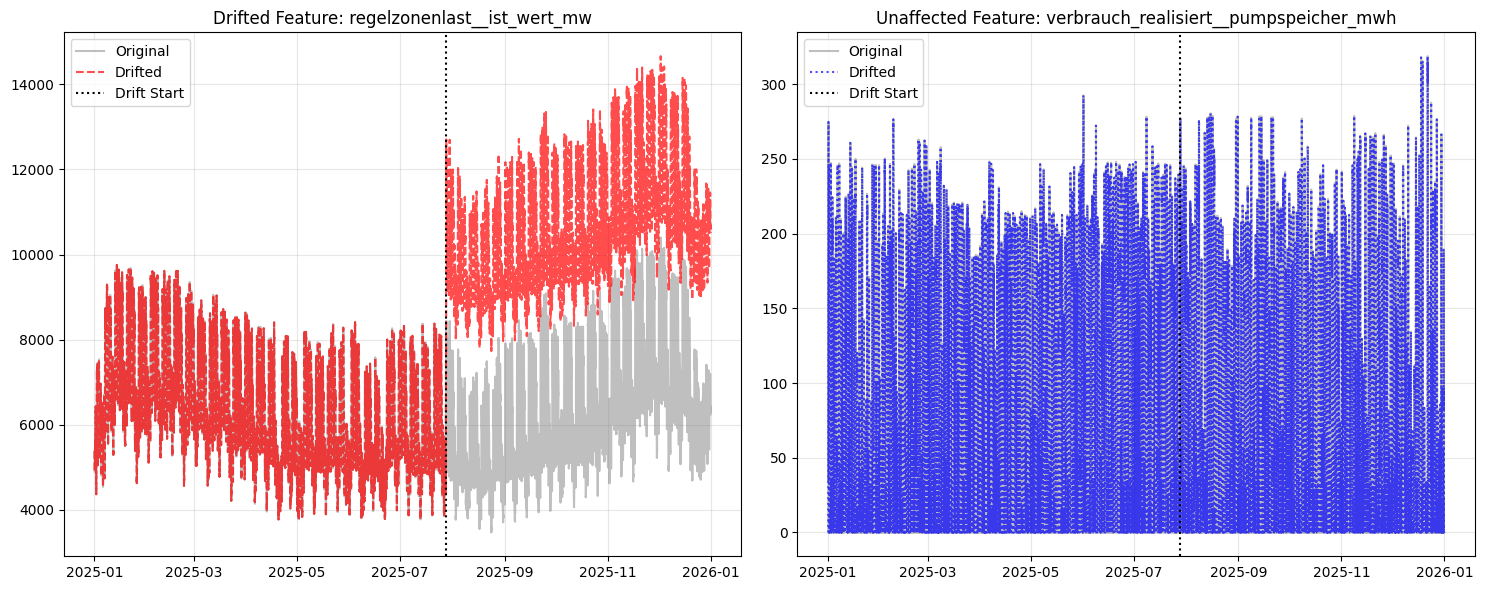

Ground Truth: Drift injected in features: ['regelzonenlast__ist_wert_mw', 'verbrauch_prog__residuallast_mwh', 'erzeugung_realisiert__pumpspeicher_mwh'] ...


In [5]:
X_mid, y = get_experimental_dataset(df_full, scenario="mid")

drift_idx = 20000  # Drift starts roughly after 2/3 of the year
magnitude = 3.0    # 3 Sigma shift (clearly visible)

# Inject Drift
X_drifted, affected_cols = inject_synthetic_drift(
    X_mid, 
    drift_start_idx=drift_idx, 
    magnitude_sigma=magnitude,
    affected_ratio=0.3 # 30% Feature Drift
)

# Visualization
affected_feat = affected_cols[0]
unaffected_feat = [c for c in X_mid.columns if c not in affected_cols][0]

plt.figure(figsize=(15, 6))

# Plot: Affected Feature
plt.subplot(1, 2, 1)
plt.plot(X_mid.index, X_mid[affected_feat], label='Original', alpha=0.5, color='gray')
plt.plot(X_drifted.index, X_drifted[affected_feat], label='Drifted', alpha=0.7, color='red', linestyle='--')
plt.axvline(X_mid.index[drift_idx], color='black', linestyle=':', label='Drift Start')
plt.title(f"Drifted Feature: {affected_feat}")
plt.legend()
plt.grid(True, alpha=0.3)

# Control Plot: Unaffected Feature
plt.subplot(1, 2, 2)
plt.plot(X_mid.index, X_mid[unaffected_feat], label='Original', alpha=0.5, color='gray')
plt.plot(X_drifted.index, X_drifted[unaffected_feat], label='Drifted', alpha=0.7, color='blue', linestyle=':') # Should overlap perfectly
plt.axvline(X_mid.index[drift_idx], color='black', linestyle=':', label='Drift Start')
plt.title(f"Unaffected Feature: {unaffected_feat}")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Ground Truth: Drift injected in features: {affected_cols[:3]} ...")

=== STARTING RO2 EXPERIMENT: CURSE OF DIMENSIONALITY ===
[INFO] Dataset prepared for scenario 'low': X shape=(35036, 10), y shape=(35036,)
[INFO] Injecting drift into 3/10 features starting at index 20000.

[START] Running experiment for scenario: 'low' (Features: 10)
   Step 0/35036 processed...
   Step 5000/35036 processed...
   Step 10000/35036 processed...
   Step 15000/35036 processed...
   Step 20000/35036 processed...
   Step 25000/35036 processed...
   Step 30000/35036 processed...
   Step 35000/35036 processed...
[DONE] Finished in 5.04s. Baseline FPR: 0.0457 | PCA FPR: 0.0049
[INFO] Dataset prepared for scenario 'mid': X shape=(35036, 40), y shape=(35036,)
[INFO] Injecting drift into 12/40 features starting at index 20000.

[START] Running experiment for scenario: 'mid' (Features: 40)
   Step 0/35036 processed...
   Step 5000/35036 processed...
   Step 10000/35036 processed...
   Step 15000/35036 processed...
   Step 20000/35036 processed...
   Step 25000/35036 processed...
 

,n_features,baseline_fpr,mitigation_fpr,baseline_latency,mitigation_latency
scenario,,,,,
low,10,0.04565,0.00485,26,102
mid,40,0.13410,0.00495,10,185
high,103,0.31150,0.00490,1,28
noise,153,0.35895,0.00490,0,32


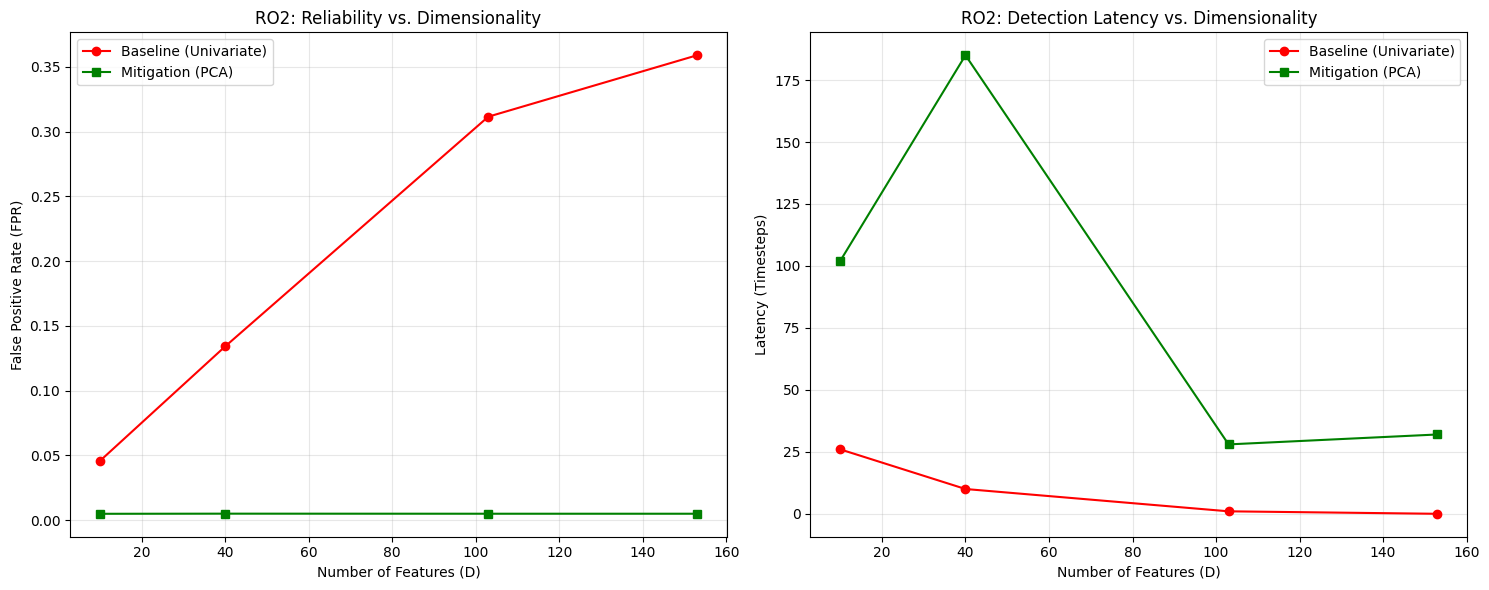

In [6]:
# Configuration for the experiment
scenarios_to_test = ["low", "mid", "high", "noise"]
drift_idx = 20000 
drift_magnitude = 3.0
drift_ratio = 0.3

all_results = []

# 2. Main Experiment Loop (Iterating through Dimensionality)
print("=== STARTING RO2 EXPERIMENT: CURSE OF DIMENSIONALITY ===")

for scen in scenarios_to_test:
    # A. Get Data
    X, y = get_experimental_dataset(df_full, scenario=scen)
    
    # B. Inject Drift (Ground Truth)
    X_drifted, affected_cols = inject_synthetic_drift(
        X, 
        drift_start_idx=drift_idx, 
        magnitude_sigma=drift_magnitude,
        affected_ratio=drift_ratio,
        random_seed=42
    )
    
    # C. Run Comparison
    res = run_comparison_experiment(
        X_drifted,
        drift_start_idx=drift_idx,
        affected_features=affected_cols,
        scenario_name=scen
    )
    
    all_results.append(res)

# 3. Create Results DataFrame
df_res = pd.DataFrame(all_results)
df_res = df_res.set_index("scenario")

# Display Table
print("\n=== FINAL RESULTS TABLE (RO2) ===")
display(df_res[["n_features", "baseline_fpr", "mitigation_fpr", "baseline_latency", "mitigation_latency"]])

# 4. Visualization (Plots for Thesis)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Reliability (False Positive Rate)
# Expectation: Baseline FPR increases with dimensions, Mitigation stays low
axes[0].plot(df_res["n_features"], df_res["baseline_fpr"], marker='o', label="Baseline (Univariate)", color='red')
axes[0].plot(df_res["n_features"], df_res["mitigation_fpr"], marker='s', label="Mitigation (PCA)", color='green')
axes[0].set_title("RO2: Reliability vs. Dimensionality")
axes[0].set_xlabel("Number of Features (D)")
axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Latency
axes[1].plot(df_res["n_features"], df_res["baseline_latency"], marker='o', label="Baseline (Univariate)", color='red')
axes[1].plot(df_res["n_features"], df_res["mitigation_latency"], marker='s', label="Mitigation (PCA)", color='green')
axes[1].set_title("RO2: Detection Latency vs. Dimensionality")
axes[1].set_xlabel("Number of Features (D)")
axes[1].set_ylabel("Latency (Timesteps)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Prepare X and y
X = df_full.drop(columns=[target_col_name])
y = df_full[target_col_name]

# Define the strategies to compare
strategies = ["baseline", "adwin", "grouped"]
results = {}

print("=== STARTING ADAPTIVE FORECASTING BATTLE ===\n")

for strat in strategies:
    # Run experiment
    # We pass 'feature_definitions' specifically for the 'grouped' strategy
    res = run_adaptive_forecasting_experiment(
        X, 
        y, 
        detector_type=strat,
        feature_groups=feature_definitions # Needed for System 3
    )
    results[strat] = res
    print("-" * 30)

print("\n=== ALL DONE ===")

=== STARTING ADAPTIVE FORECASTING BATTLE ===


[EXP] Starting Adaptive Forecasting with Strategy: BASELINE
[RESULT] Strategy: baseline | RMSE: 15.1792 | Retrainings: 0
------------------------------

[EXP] Starting Adaptive Forecasting with Strategy: ADWIN
[RESULT] Strategy: adwin | RMSE: 49.3041 | Retrainings: 41
------------------------------

[EXP] Starting Adaptive Forecasting with Strategy: GROUPED
[RESULT] Strategy: grouped | RMSE: 23.7721 | Retrainings: 59
------------------------------

=== ALL DONE ===


In [8]:
# Create a comparison dataframe
comparison_data = []

for strat, res in results.items():
    comparison_data.append({
        "Strategy": strat.upper(),
        "RMSE": res["rmse"],
        "Retrainings": len(res["retrain_steps"]),
        "Last_Retrain_Step": res["retrain_steps"][-1] if res["retrain_steps"] else 0
    })

df_comp = pd.DataFrame(comparison_data).sort_values("RMSE")

print("Final Results Table:")
display(df_comp)

Final Results Table:


,Strategy,RMSE,Retrainings,Last_Retrain_Step
0,BASELINE,15.179175,0,0
2,GROUPED,23.772053,59,29557
1,ADWIN,49.304099,41,29823


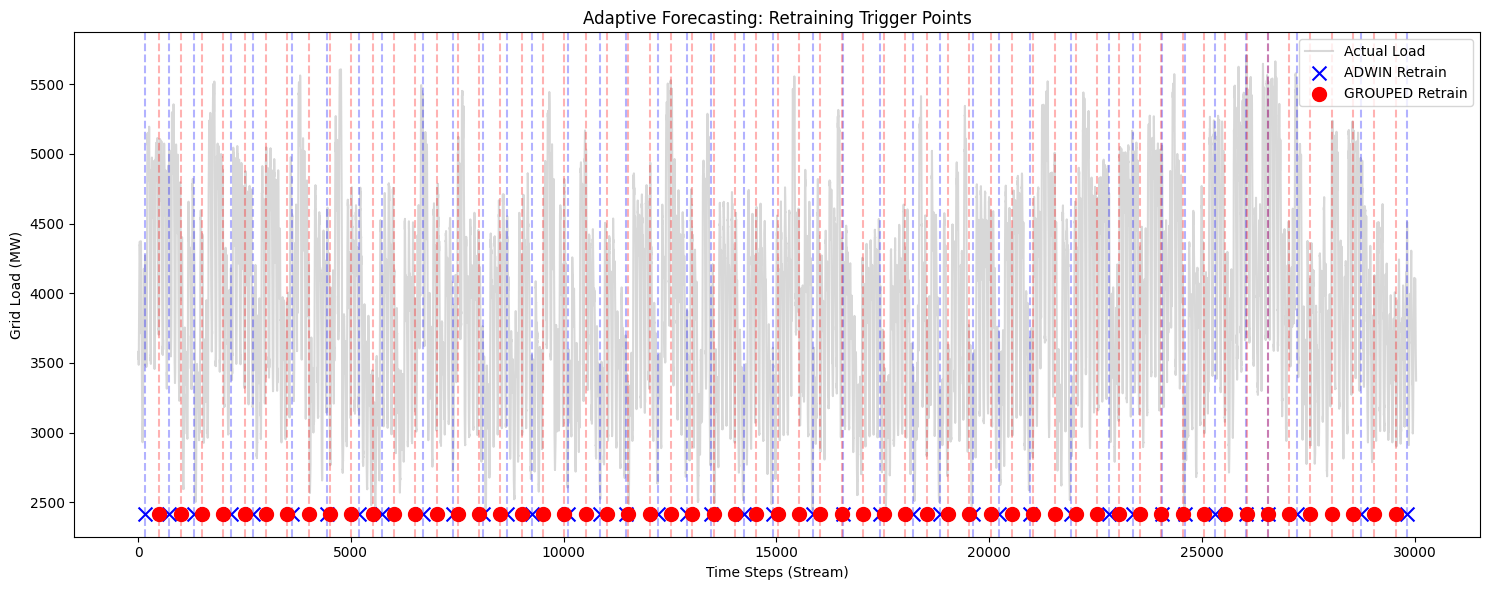

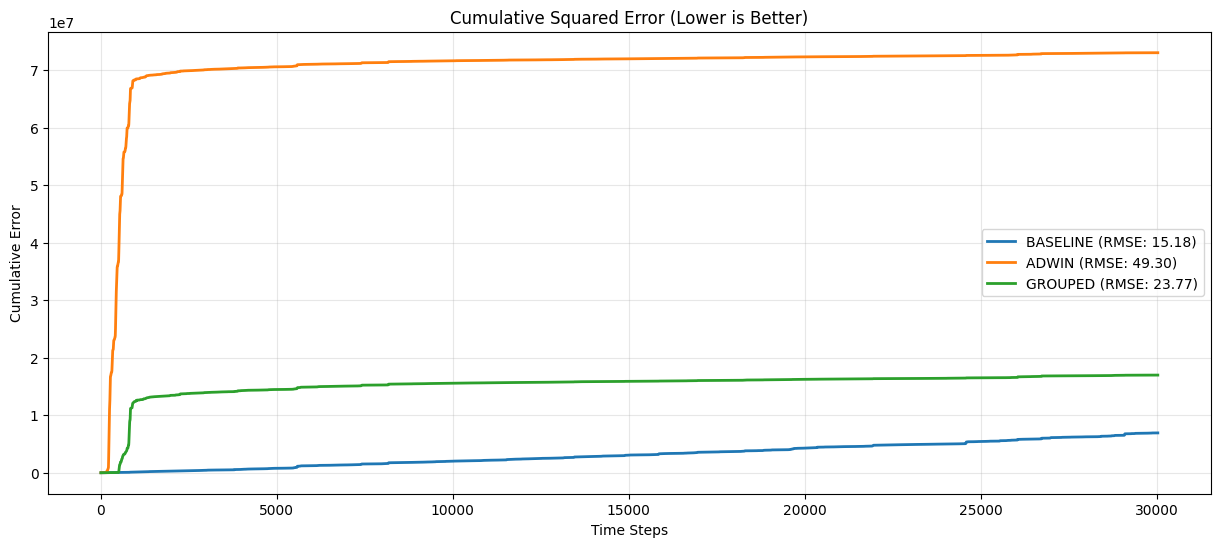

In [9]:
# Plotting the Retraining Points
plt.figure(figsize=(15, 6))

# 1. Plot the actual Target (Light gray in background)
# We take the actuals from one of the results (they are the same for all)
actual_values = results["baseline"]["actuals"]
plt.plot(actual_values, color='gray', alpha=0.3, label="Actual Load")

# 2. Plot Retraining Events for each strategy
colors = {"baseline": "black", "adwin": "blue", "grouped": "red"}
markers = {"baseline": "", "adwin": "x", "grouped": "o"}

# Offset for visualization (so dots don't overlap perfectly)
y_min = min(actual_values)
offsets = {"baseline": 0, "adwin": y_min * 0.05, "grouped": y_min * 0.1}

for strat in ["adwin", "grouped"]:
    steps = results[strat]["retrain_steps"]
    # We plot vertical lines or dots where retraining happened
    # Since 'steps' are indices relative to the stream start:
    y_vals = [min(actual_values)] * len(steps) # Plot dots at the bottom
    
    plt.scatter(steps, y_vals, color=colors[strat], marker=markers[strat], s=100, label=f"{strat.upper()} Retrain", zorder=5)
    
    # Optional: Vertical lines
    for s in steps:
        plt.axvline(s, color=colors[strat], alpha=0.3, linestyle="--")

plt.title("Adaptive Forecasting: Retraining Trigger Points")
plt.xlabel("Time Steps (Stream)")
plt.ylabel("Grid Load (MW)")
plt.legend()
plt.tight_layout()
plt.show()

# Extra Plot: Cumulative Error (Who is better over time?)
plt.figure(figsize=(15, 6))

for strat in strategies:
    preds = results[strat]["predictions"]
    acts = results[strat]["actuals"]
    
    # Calculate Squared Error per step
    se = (np.array(preds) - np.array(acts)) ** 2
    # Cumulative Sum
    cse = np.cumsum(se)
    
    plt.plot(cse, label=f"{strat.upper()} (RMSE: {results[strat]['rmse']:.2f})", linewidth=2)

plt.title("Cumulative Squared Error (Lower is Better)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()